In [1]:
from geqo.core import Sequence, BasicGate
from geqo.gates import PauliX, Phase
from geqo.operations import QuantumControl
from geqo.simulators import unitarySimulatorCuPy
from geqo.algorithms import (
    decompose_mcx,
    decompose_mcu,
    decompose_mcp,
    unitaryDecomposer,
)
from geqo.visualization import plot_mpl
import numpy as np

c:\Users\keygo\Anaconda3\envs\geqo\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
sim = unitarySimulatorCuPy(8)
sim.apply(QuantumControl([0, 1, 1, 0], PauliX()), [0, 1, 2, 5, 7])
u1 = sim.u

sim2 = unitarySimulatorCuPy(8)
de_seq, _ = decompose_mcx([0, 1, 1, 0], [0, 1, 2, 5, 7], 8)
# sim2.prepareBackend([Toffoli()])
sim2.apply(de_seq, [*range(8)])
u2 = sim2.u
np.sum(abs(u1 - u2))

np.float64(0.0)

In [6]:
sim = unitarySimulatorCuPy(6)
sim.apply(QuantumControl([0, 1, 0, 1], PauliX()), [0, 1, 4, 2, 5])
u1 = sim.u

sim2 = unitarySimulatorCuPy(6)
de_seq, params = decompose_mcx([0, 1, 0, 1], [0, 1, 4, 2, 5], 6)
# sim2.prepareBackend([Toffoli()])
sim2.values = params
sim2.apply(de_seq, [*range(6)])
u2 = sim2.u
np.sum(abs(u1 - u2))

np.float64(0.0)

In [7]:
sim = unitarySimulatorCuPy(7)
sim.apply(QuantumControl([1, 1, 0, 0], PauliX()), [0, 1, 4, 2, 6])
u1 = sim.u

sim2 = unitarySimulatorCuPy(7)
de_seq, params = decompose_mcx([1, 1, 0, 0], [0, 1, 4, 2, 6], 7)
# sim2.prepareBackend([Toffoli()])
sim2.values = params
sim2.apply(de_seq, [*range(7)])
u2 = sim2.u
np.sum(abs(u1 - u2))

np.float64(6.453299105295986e-14)

In [8]:
def W(theta, phi, lam):
    return np.array(
        [
            [np.cos(theta / 2), -np.exp(1j * lam) * np.sin(theta / 2)],
            [
                np.exp(1j * phi) * np.sin(theta / 2),
                np.exp(1j * (phi + lam)) * np.cos(theta / 2),
            ],
        ]
    )

In [9]:
onoff = [0, 0, 0, 0, 0]
N = len(onoff)
sim0 = unitarySimulatorCuPy(N + 2)
bg = BasicGate("a", 1)
sim0.setValue("a", W(1.23, -0.5, 2.69))
sim0.apply(QuantumControl(onoff, bg), [0, 3, 4, 1, 5, 2])
expected = sim0.u

seq, params = decompose_mcu(W(1.23, -0.5, 2.69), onoff, [0, 3, 4, 1, 5, 2], N + 2)
sim = unitarySimulatorCuPy(N + 2)
sim.values = params

sim.apply(seq, [*range(N + 2)])
predict = sim.u

np.sum(abs(expected - predict))

np.float64(1.552519653200748e-13)

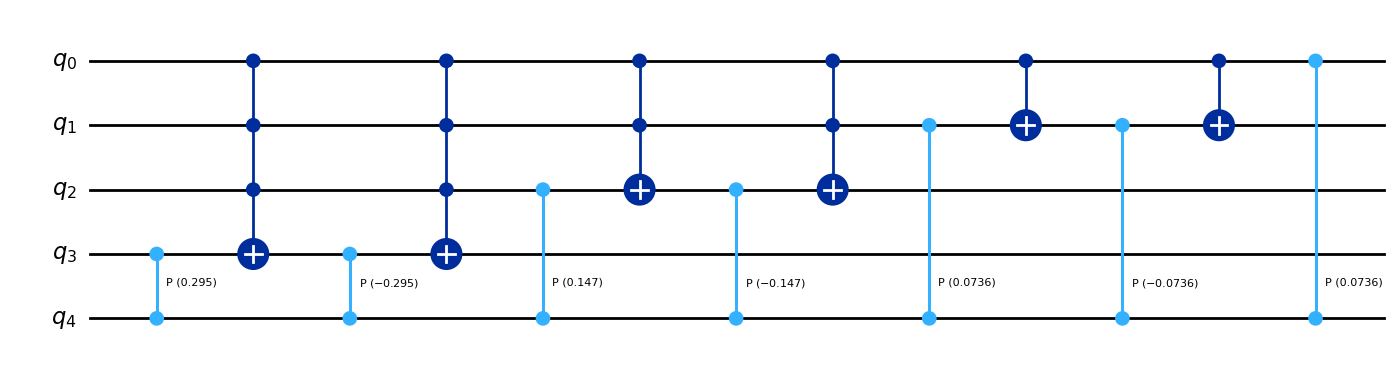

In [22]:
from qiskit import QuantumCircuit
import numpy as np
from math import pi


def decompose_mcp_qiskit(theta, onoff, targets):
    """
    Converts the geqo 'decompose_mcp' logic into a Qiskit QuantumCircuit.

    This function *directly* implements the gate sequence from the geqo function,
    but uses Qiskit's indexing (qubit 0 is LSB). The decomposition appears to be
    for a multi-controlled P(theta) gate.

    Args:
        theta (float): The angle for the phase/RZ gate.
        onoff (list[int]): Specifies the control state (1 for |1>, 0 for |0>).
        targets (list[int]): The list of control qubits followed by the target qubit.
                             e.g., [c1, c2, ..., cn, t]

    Returns:
        QuantumCircuit: The Qiskit circuit implementing the decomposition.
    """
    if len(onoff) != len(targets) - 1:
        raise ValueError("Number of control qubits do not match the specified targets")

    num_qubits = max(targets) + 1  # Total number of qubits needed
    qc = QuantumCircuit(num_qubits)

    target = targets[-1]
    ctrls = targets[:-1]

    # 1. Handle "anti-controls" (onoff=0) by wrapping with X gates
    anti_controls = [ctrls[idx] for idx, value in enumerate(onoff) if value == 0]

    # Apply X gates to anti-controls
    for ctrl in anti_controls:
        qc.x(ctrl)

    # --- Decompositions ---

    if len(onoff) == 1:  # Controlled-Phase (CP) gate decomposition
        # Targets is [c0, t]

        # op.append((CNOT(), targets, [])) # CNOT(c0, t)
        qc.cx(ctrls[0], target)

        # op.append((Rz("-θ/2"), [target], [])) # Rz(-θ/2) on target
        qc.rz(-theta / 2, target)

        # op.append((CNOT(), targets, [])) # CNOT(c0, t)
        qc.cx(ctrls[0], target)

        # op.append((Rz("θ/2"), [target], [])) # Rz(θ/2) on target
        qc.rz(theta / 2, target)

        # op.append((Phase("θ/2"), ctrls, [])) # P(θ/2) on control
        qc.p(theta / 2, ctrls[0])

    else:  # Multi-Controlled Phase (MCP) decomposition for n > 1 controls
        # This part of the geqo code seems to implement a recursive-style
        # decomposition, possibly based on the standard MCP decomposition using
        # CNOT/CCNOT and controlled rotations/phases.
        # We need to *exactly* follow the operations listed in the geqo function:

        # The geqo code uses ctrls[-(1+r)] as the last_ctrl, which means
        # it iterates backwards through the control qubits starting from the
        # second-to-last control.

        num_controls = len(onoff)
        r_range = range(num_controls - 1)

        for r in r_range:
            last_ctrl = ctrls[-(1 + r)]
            alpha = theta / (2 ** (1 + r))

            # op.append((QuantumControl([1],Phase(f"+{r}")), [last_ctrl, target], []))
            # Controlled-P(alpha) on last_ctrl, target
            qc.cp(alpha, last_ctrl, target)

            # op.append((QuantumControl([1] * (len(onoff)-1-r), PauliX()), ctrls[:len(onoff)-r], []))
            # Multi-Controlled X (MCX) / Toffoli. Controls are ctrls[0] up to ctrls[len(onoff)-1-r-1], target is ctrls[len(onoff)-1-r]
            # Controls are: ctrls[0]...ctrls[num_controls - 2 - r], Target is: ctrls[num_controls - 1 - r]
            mcx_target = ctrls[num_controls - 1 - r]
            mcx_controls = ctrls[: num_controls - 1 - r]

            # Ensure controls list is not empty for MCX (it shouldn't be for r < num_controls - 1)
            if mcx_controls:
                # The geqo code logic is a bit unusual here, interpreting it as:
                # Target: ctrls[len(onoff)-r - 1]
                # Controls: ctrls[:len(onoff)-r - 1]
                qc.mcx(control_qubits=mcx_controls, target_qubit=mcx_target)

            # op.append((QuantumControl([1],Phase(f"-{r}")), [last_ctrl, target], []))
            # Controlled-P(-alpha) on last_ctrl, target
            qc.cp(-alpha, last_ctrl, target)

            # op.append((QuantumControl([1] * (len(onoff)-1-r), PauliX()), ctrls[:len(onoff)-r], []))
            # Repeat of the MCX/Toffoli
            if mcx_controls:
                qc.mcx(control_qubits=mcx_controls, target_qubit=mcx_target)

        # The final controlled-phase
        # op.append((QuantumControl([1],Phase(f"+{r}")), [ctrls[0], target],[]))
        qc.cp(theta / (2 ** (num_controls - 1)), ctrls[0], target)

    # 2. Un-handle "anti-controls" by unwrapping X gates
    # This must be done *after* the decomposition
    for ctrl in anti_controls:
        qc.x(ctrl)

    return qc


# --- Example Usage (Convert and Simulate) ---

# Example: Controlled-Controlled-Phase (CCP) gate on qubits 0, 1, and 2
# geqo: targets = [0, 1, 2] means c1=0 (MSB), c2=1, t=2
# onoff = [1, 1] means control on |11>
theta_val = pi / 3
geqo_targets = [0, 1, 2]  # geqo's indices: C0, C1, T
onoff_states = [1, 1]
theta = 3 * np.pi / 16
onoff = [1, 1, 1, 1]
targets = [0, 1, 2, 3, 4]
# onoff = [1,0,1,0]
# targets = [0,3,4,2,1]

# The Qiskit circuit will use the same indices for the qubits.
# Qiskit Qubit Indices: Q0, Q1, Q2.
# C0=0, C1=1, T=2
qc_mcp = decompose_mcp_qiskit(theta, onoff, targets)
qc_mcp.draw("mpl")

In [23]:
from qiskit.quantum_info import Operator


def permute_unitary_lsb_to_msb(unitary_lsb):
    """Permutes a Qiskit (LSB) unitary matrix to the geqo (MSB) convention."""

    dim = unitary_lsb.shape[0]
    N = int(np.log2(dim))

    # Create the permutation array
    perm_array = np.zeros(dim, dtype=int)
    for k in range(dim):
        # 1. Get the binary string for index k (LSB order: q_{N-1}...q_0)
        bin_str = format(k, f"0{N}b")
        # 2. Reverse the binary string for MSB order (q_0...q_{N-1})
        reversed_bin_str = bin_str[::-1]
        # 3. The new index k' is the decimal value of the reversed string
        k_prime = int(reversed_bin_str, 2)
        perm_array[k] = k_prime

    # The geqo (MSB) matrix rows/columns are reordered by the permutation array.
    # U_msb[i, j] = U_lsb[perm[i], perm[j]]
    # Since the permutation array maps LSB index to MSB index:
    # U_msb(k') = U_lsb(k)
    # The array should map the desired MSB row/col index (k_prime) back to
    # the LSB row/col index (k).

    # The perm_array we created maps LSB_index -> MSB_index.
    # We need to map MSB_index -> LSB_index for matrix permutation.
    inverse_perm_array = np.argsort(perm_array)

    # Permute rows and columns
    unitary_msb = unitary_lsb[inverse_perm_array, :]
    unitary_msb = unitary_msb[:, inverse_perm_array]

    return unitary_msb


# Get the unitary matrix (Operator)
unitary_op = Operator(qc_mcp)

# Convert the Operator to a NumPy array for standard matrix representation
unitary_lsb = unitary_op.data
unitary_msb = permute_unitary_lsb_to_msb(unitary_lsb)


print("\n## 🔢 Total Unitary Matrix (NumPy Array)")
# Print with higher precision for better inspection
np.set_printoptions(precision=4, suppress=True)
print(unitary_msb)
print(f"\nMatrix Shape: {unitary_msb.shape}")


## 🔢 Total Unitary Matrix (NumPy Array)
[[ 1.    +0.j      0.    +0.j      0.    +0.j     ...  0.    +0.j
   0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      1.    -0.j      0.    +0.j     ...  0.    +0.j
   0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j     ...  0.    +0.j
   0.    +0.j      0.    +0.j    ]
 ...
 [ 0.    +0.j      0.    +0.j      0.    +0.j     ...  1.    +0.j
   0.    +0.j      0.    -0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j     ...  0.    +0.j
   1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j     ... -0.    -0.j
   0.    +0.j      0.8315+0.5556j]]

Matrix Shape: (32, 32)


In [8]:
theta = 3 * np.pi / 16
onoff = [1, 0, 1, 0, 0, 1]
targets = [0, 1, 3, 4, 2, 6, 5]
# onoff = [1,0,1,0]
# targets = [0,3,4,2,1]
n = len(targets) + 1
seq, params = decompose_mcp(theta, onoff, targets, n)
sim = unitarySimulatorCuPy(n)
sim.values = params
sim.apply(seq, [*range(n)])
result = sim.u

sim1 = unitarySimulatorCuPy(n)
sim1.setValue("theta", theta)
sim1.apply(QuantumControl(onoff, Phase("theta")), targets)
expect = sim1.u
"""expect = np.eye(2**n,dtype=complex)
#pow = np.array([2**(n-1-i) for i in targets])
#index = np.dot(pow,np.array(onoff+[1]))
index = bin2num(onoff
expect[2*index+1,2*index+1] = np.exp(1j*theta)
#expect[index,index] = np.exp(1j*theta)"""

np.sum(abs(result - expect))

np.float64(3.2344049524047396e-13)

In [9]:
params

{'-0.2945243112740431/2': -0.14726215563702155,
 '0.2945243112740431/2': 0.14726215563702155,
 '-0.14726215563702155/2': -0.07363107781851078,
 '0.14726215563702155/2': 0.07363107781851078,
 '-0.07363107781851078/2': -0.03681553890925539,
 '0.07363107781851078/2': 0.03681553890925539,
 '-0.03681553890925539/2': -0.018407769454627694,
 '0.03681553890925539/2': 0.018407769454627694,
 '-0.018407769454627694/2': -0.009203884727313847,
 '0.018407769454627694/2': 0.009203884727313847}

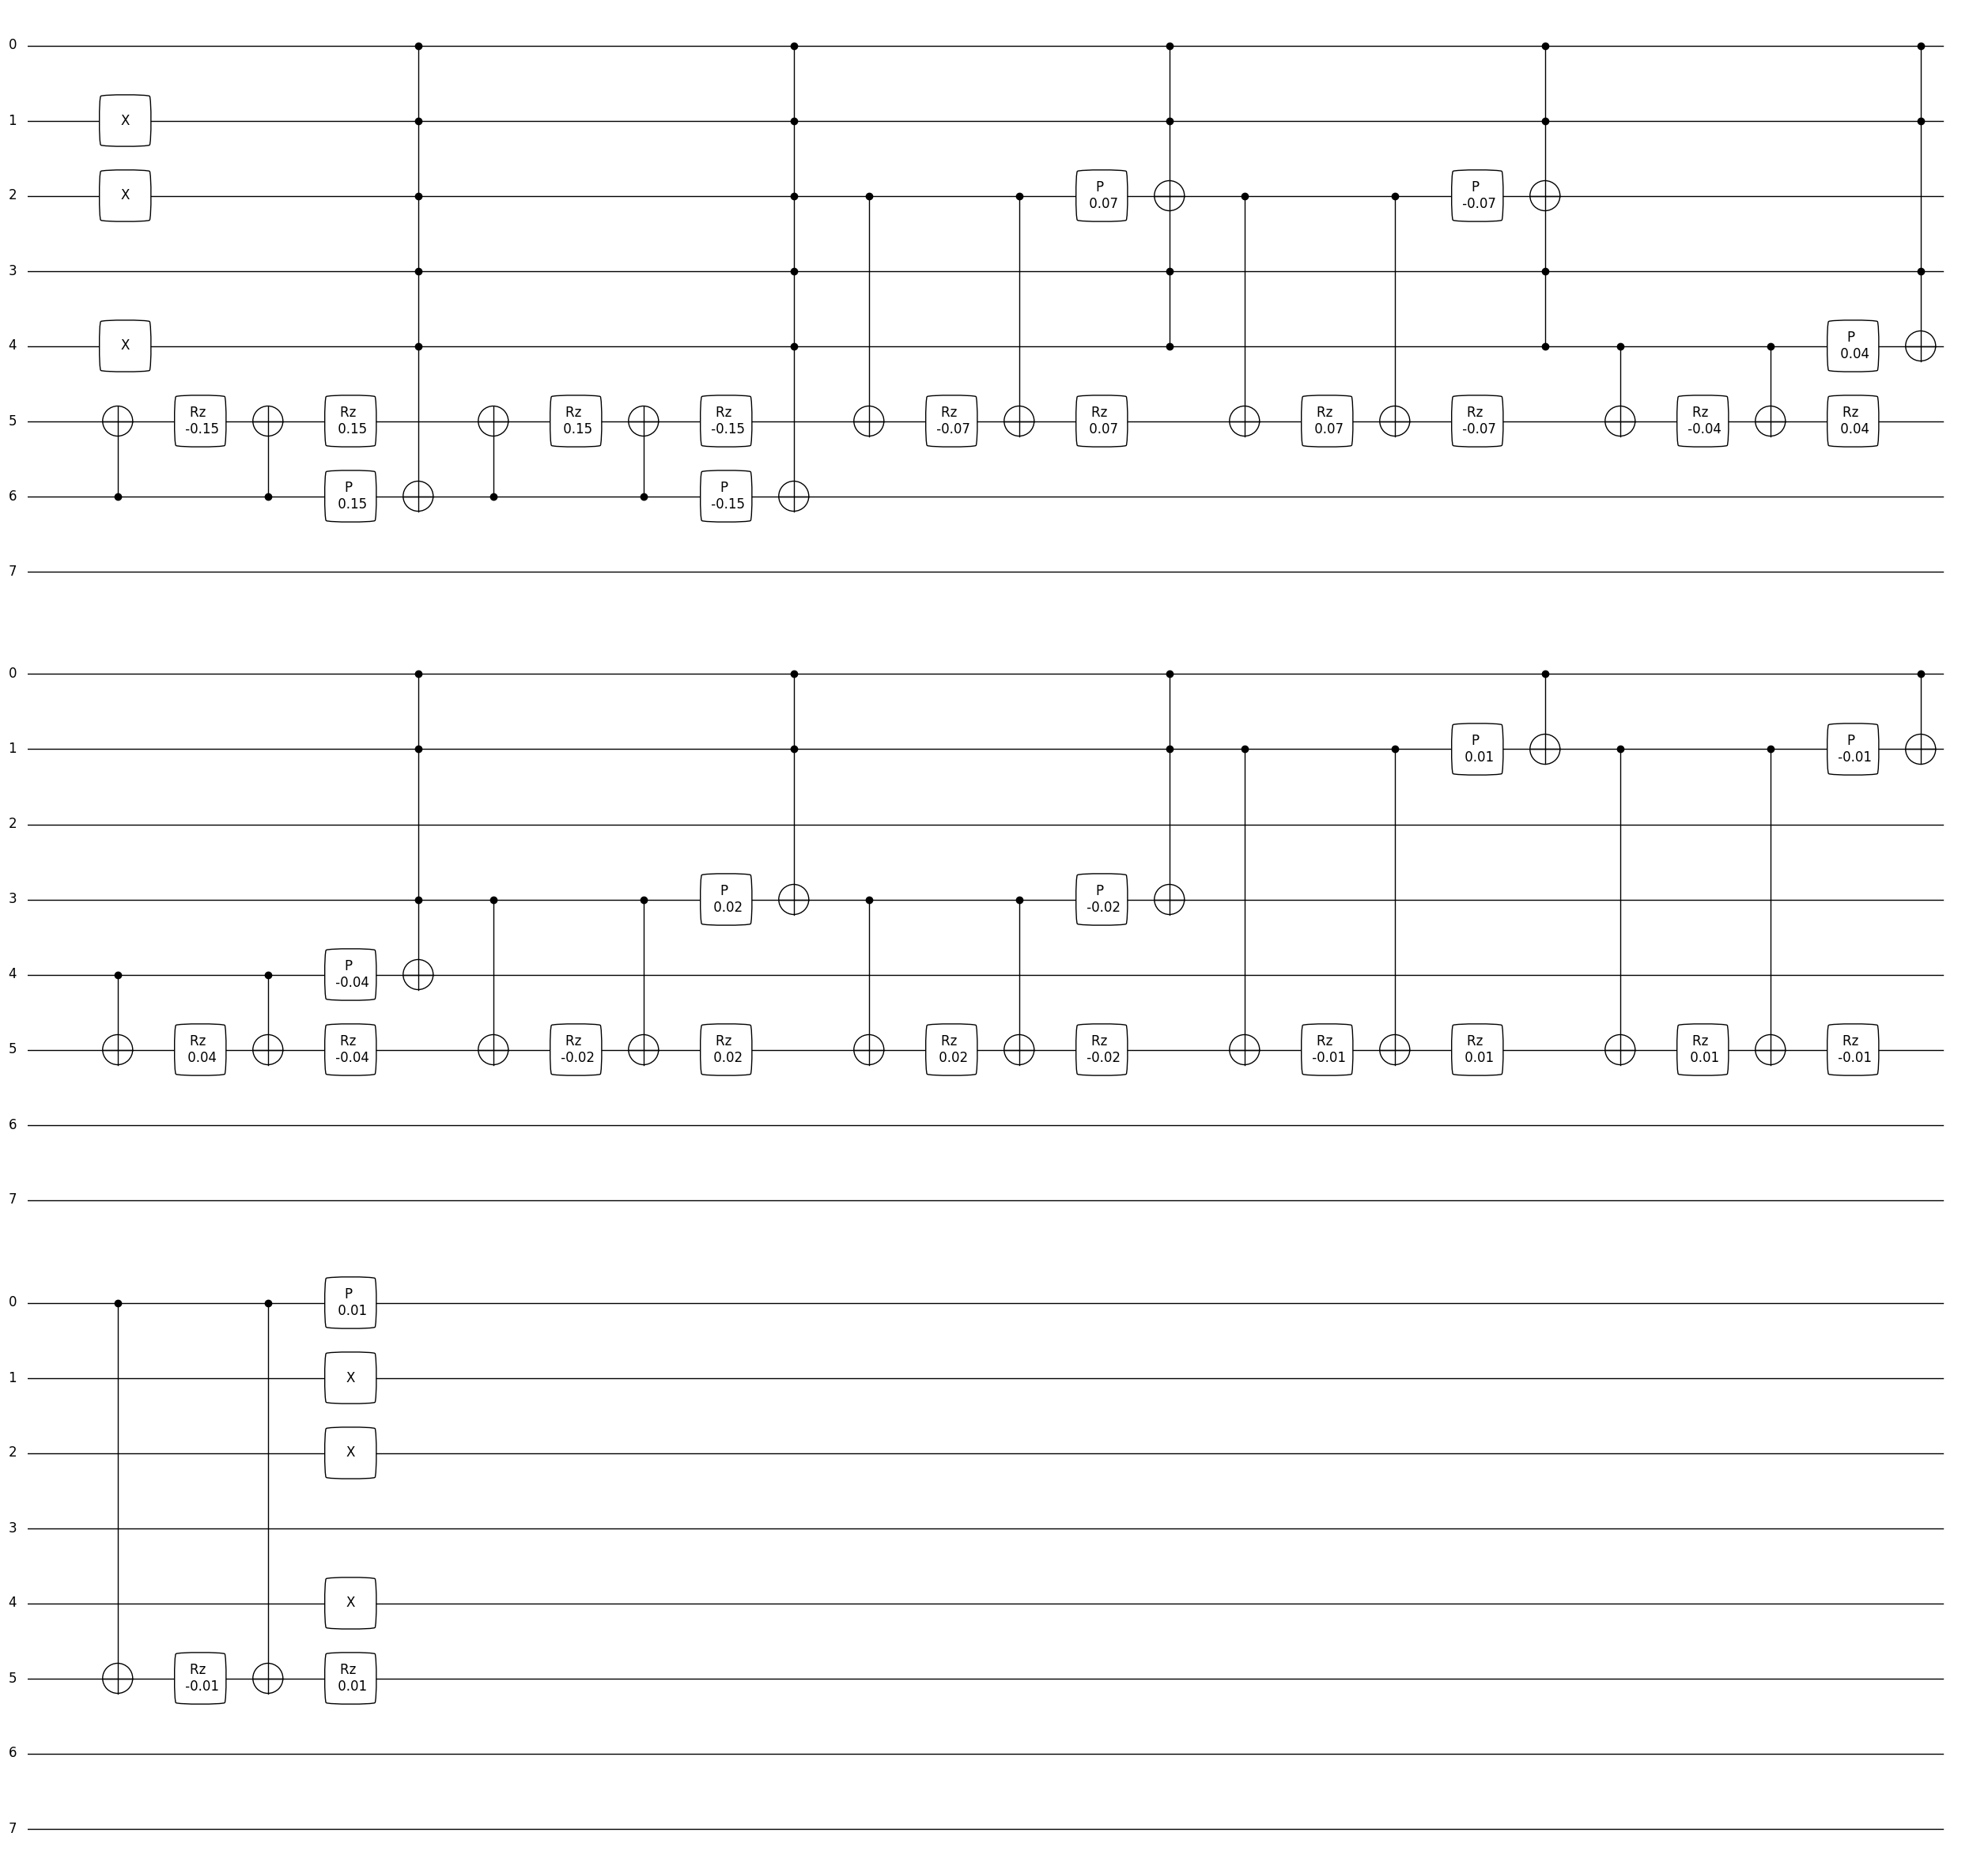

In [10]:
plot_mpl(seq, backend=sim)

{'G03': array([[ 0.+0.j,  1.+0.j],
       [-1.+0.j,  0.-0.j]]), '-3.141592653589793': np.float64(-3.141592653589793), 'G12': array([[ 0.-0.j,  1.-0.j],
       [-1.-0.j,  0.+0.j]])}


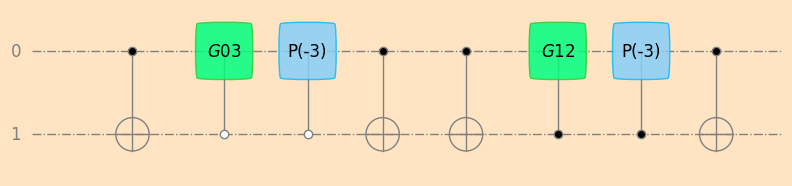

In [2]:
import numpy as np

xx = np.array(
    [
        [0.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j, 1.0 + 0.0j],
        [0.0 + 0.0j, 0.0 + 0.0j, 1.0 + 0.0j, 0.0 + 0.0j],
        [0.0 + 0.0j, 1.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j],
        [1.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j],
    ]
)
seqxx, paramxx = unitaryDecomposer(xx)
plot_mpl(seqxx, style="geqo")
print(paramxx)

[[-2.9194952e-17+9.24446373e-33j  0.0000000e+00+0.00000000e+00j
   0.0000000e+00+0.00000000e+00j  1.0000000e+00+1.11022302e-16j]
 [ 0.0000000e+00+0.00000000e+00j -1.1434503e-16-1.93275654e-32j
   1.0000000e+00+1.72254642e-16j  0.0000000e+00+0.00000000e+00j]
 [ 0.0000000e+00+0.00000000e+00j  1.0000000e+00+1.72254642e-16j
  -3.5840407e-17-5.27607990e-33j  0.0000000e+00+0.00000000e+00j]
 [ 1.0000000e+00+1.11022302e-16j  0.0000000e+00+0.00000000e+00j
   0.0000000e+00+0.00000000e+00j -2.9194952e-17+0.00000000e+00j]]


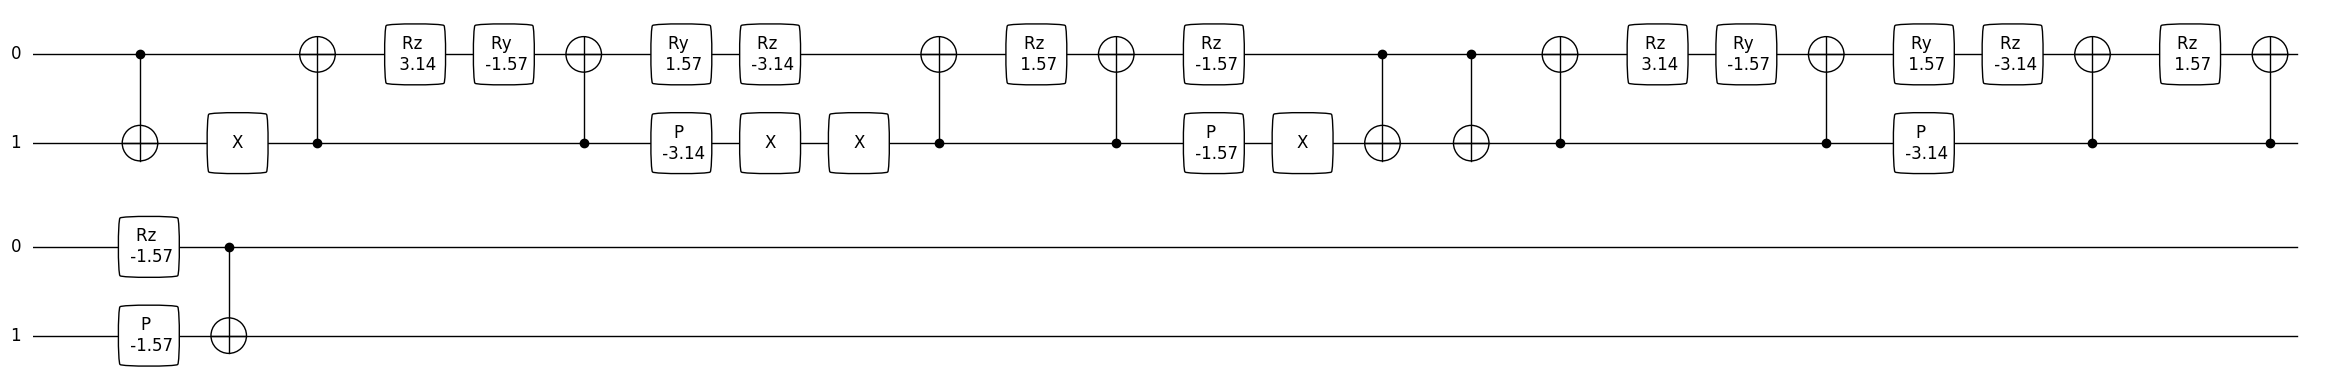

In [4]:
op = []
de_params = {}
for gnt in seqxx.gatesAndTargets:
    gate = gnt[0]
    qtargets = gnt[1]
    ctargets = gnt[2]
    if isinstance(gate, QuantumControl) and isinstance(gate.qop, BasicGate):
        u = paramxx[gate.qop.name]
        givens_seq, givens_params = decompose_mcu(
            u, gate.onoff, qtargets, seqxx.getNumberQubits()
        )
        for g in givens_seq.gatesAndTargets:
            op.append(g)
        de_params.update(givens_params)
    elif isinstance(gate, QuantumControl) and isinstance(gate.qop, Phase):
        theta = paramxx[gate.qop.name]
        phase_seq, phase_params = decompose_mcp(
            theta, gate.onoff, qtargets, seqxx.getNumberQubits()
        )
        for g in phase_seq.gatesAndTargets:
            op.append(g)
        de_params.update(phase_params)
    else:
        op.append(gnt)

de_seq = Sequence(seqxx.qubits, seqxx.bits, op)
sim = unitarySimulatorCuPy(2)
sim.values = de_params
sim.apply(de_seq, [0, 1])
output = sim.u
print(output)
plot_mpl(de_seq, backend=sim)

In [5]:
de_seq

Sequence([0, 1], [], [(CNOT(), [0, 1], []), (PauliX(), [1], []), (CNOT(), [1, 0], []), (Rz("--6.283185307179586/2"), [0], []), (Ry("-3.141592653589793/2"), [0], []), (CNOT(), [1, 0], []), (Ry("3.141592653589793/2"), [0], []), (Rz("-3.141592653589793"), [0], []), (PauliX(), [1], []), (PauliX(), [1], []), (CNOT(), [1, 0], []), (Rz("--3.141592653589793/2"), [0], []), (CNOT(), [1, 0], []), (Rz("-3.141592653589793/2"), [0], []), (Phase("-3.141592653589793/2"), [1], []), (PauliX(), [1], []), (CNOT(), [0, 1], []), (CNOT(), [0, 1], []), (CNOT(), [1, 0], []), (Rz("--6.283185307179586/2"), [0], []), (Ry("-3.141592653589793/2"), [0], []), (CNOT(), [1, 0], []), (Ry("3.141592653589793/2"), [0], []), (Rz("-3.141592653589793"), [0], []), (CNOT(), [1, 0], []), (Rz("--3.141592653589793/2"), [0], []), (CNOT(), [1, 0], []), (Rz("-3.141592653589793/2"), [0], []), (Phase("-3.141592653589793/2"), [1], []), (CNOT(), [0, 1], [])])

In [5]:
np.sum(abs(output - xx))

np.float64(2.951409080030308e-15)

[[ 3.89619873e-17-2.28483135e-17j  3.75732503e-01+5.31907095e-01j
  -5.56279530e-35+2.44870870e-34j  1.69555074e-16-2.09603532e-16j
  -5.08536716e-17-8.76448638e-17j -6.19833612e-01+4.37842692e-01j
   3.40992210e-32+3.15374367e-32j -4.87873191e-32+9.82863934e-32j
  -2.05889653e-17-1.45868248e-17j -1.17798969e-17-3.25437044e-16j
   2.90981220e-32-5.45576280e-34j -5.38177184e-32+1.55638823e-32j
  -3.83364955e-16-1.41879099e-18j  2.15370087e-16-9.35316116e-17j
  -1.18148139e-31+9.61609767e-32j  2.17991818e-16-2.44581250e-16j]
 [-2.71089307e-17-2.13041470e-16j  1.23392257e-16-3.62133893e-16j
  -3.58772337e-33+9.50181949e-33j  1.67485822e-32+3.41955640e-32j
   1.79562420e-16-6.04310014e-17j -1.85850189e-16-2.74010390e-16j
   1.24217053e-33-4.14431147e-33j  4.50716111e-16+1.49817787e-16j
  -3.40807667e-16-1.40824377e-16j -3.75732503e-01+5.31907095e-01j
   4.63274525e-33-3.35575710e-32j -5.26151872e-17+6.86192125e-18j
  -1.10420511e-16-1.67318463e-16j -6.19833612e-01-4.37842692e-01j
   7.4369

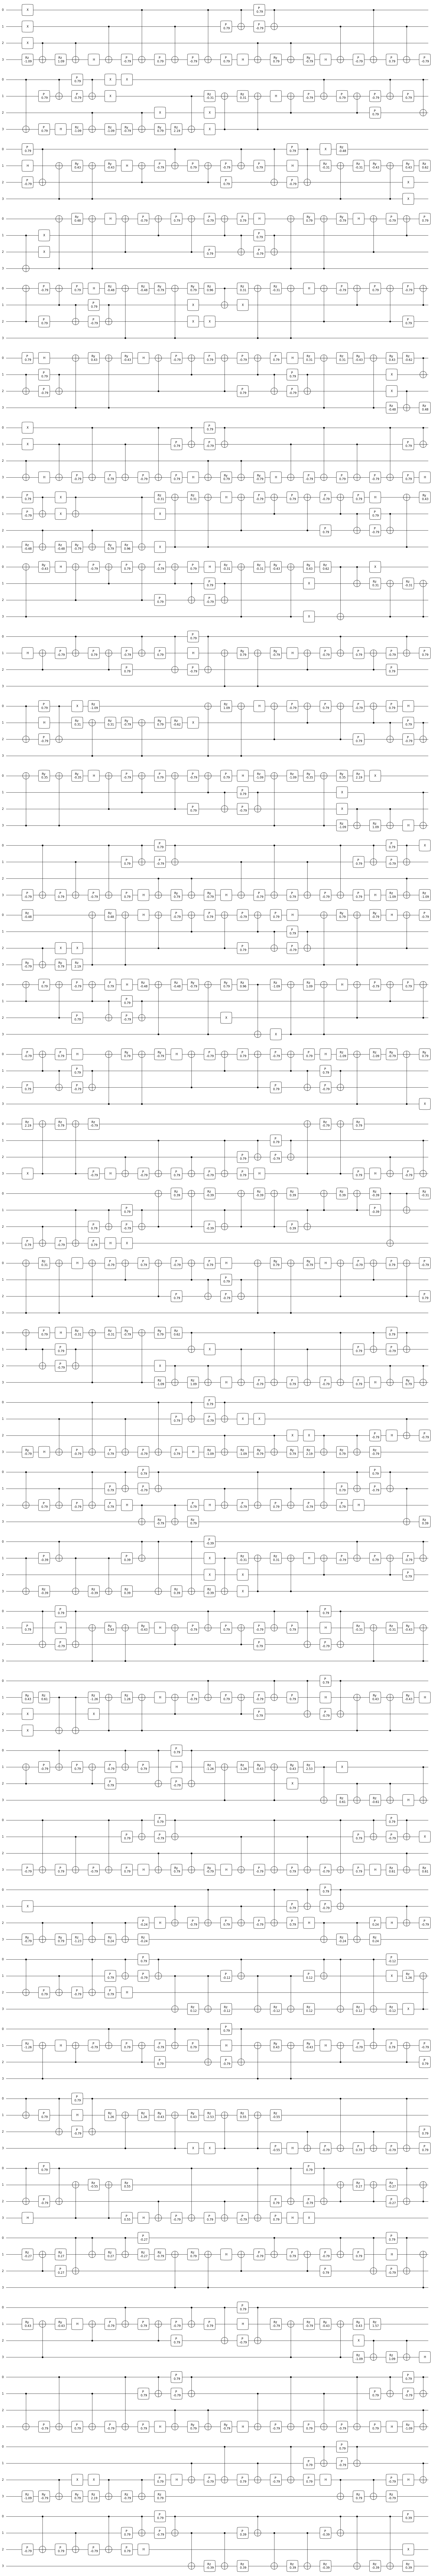

In [6]:
from geqo.gates import PauliY, Rzz, Toffoli, SwapQubits, Rx

random2 = Sequence(
    [0, 1, 2, 3],
    [],
    [
        (PauliY(), [3], []),
        (Rzz("a"), [0, 2], []),
        (Toffoli(), [2, 1, 0], []),
        (SwapQubits(), [0, 3], []),
        (Rx("b"), [1], []),
    ],
)

sim = unitarySimulatorCuPy(4)
sim.setValue("a", 1.23)
sim.setValue("b", 4.56)
sim.prepareBackend([Toffoli()])
sim.apply(random2, [0, 1, 2, 3])
u2 = sim.u
seq_u2, u2_params = unitaryDecomposer(u2)

op = []
de_params = {}
for gnt in seq_u2.gatesAndTargets:
    gate = gnt[0]
    qtargets = gnt[1]
    ctargets = gnt[2]
    if isinstance(gate, QuantumControl) and isinstance(gate.qop, BasicGate):
        u = u2_params[gate.qop.name]
        givens_seq, givens_params = decompose_mcu(
            u, gate.onoff, qtargets, seq_u2.getNumberQubits()
        )
        for g in givens_seq.gatesAndTargets:
            op.append(g)
        de_params.update(givens_params)
    elif isinstance(gate, QuantumControl) and isinstance(gate.qop, Phase):
        theta = u2_params[gate.qop.name]
        phase_seq, phase_params = decompose_mcp(
            theta, gate.onoff, qtargets, seq_u2.getNumberQubits()
        )
        for g in phase_seq.gatesAndTargets:
            op.append(g)
        de_params.update(phase_params)
    else:
        op.append(gnt)

de_seq = Sequence(seq_u2.qubits, seq_u2.bits, op)
sim = unitarySimulatorCuPy(4)
sim.values = de_params
sim.apply(de_seq, [*range(4)])
output = sim.u
print(output)
plot_mpl(de_seq, backend=sim)

In [7]:
np.sum(abs(output - u2))

np.float64(8.570691275161806e-14)